In [23]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.datasets as ds

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder, StandardScaler, MaxAbsScaler, QuantileTransformer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

%matplotlib inline

In [3]:
# Data reading

data = ds.fetch_openml('credit-g', as_frame=True).frame

data.sample(10)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
891,no checking,15.0,critical/other existing credit,radio/tv,1829.0,<100,>=7,4.0,male single,none,4.0,car,46.0,none,own,2.0,skilled,1.0,yes,yes,good
578,0<=X<200,36.0,critical/other existing credit,new car,2820.0,<100,<1,4.0,male div/sep,none,4.0,car,27.0,none,own,2.0,skilled,1.0,none,yes,bad
810,0<=X<200,8.0,existing paid,business,907.0,<100,<1,3.0,male mar/wid,none,2.0,real estate,26.0,none,own,1.0,skilled,1.0,yes,yes,good
520,no checking,24.0,critical/other existing credit,repairs,5507.0,<100,>=7,3.0,male single,none,4.0,no known property,44.0,none,for free,2.0,skilled,1.0,none,yes,good
803,no checking,12.0,critical/other existing credit,radio/tv,976.0,no known savings,>=7,4.0,male single,none,4.0,car,35.0,none,own,2.0,skilled,1.0,none,yes,good
267,no checking,24.0,existing paid,radio/tv,1533.0,<100,<1,4.0,female div/dep/mar,none,3.0,car,38.0,stores,own,1.0,skilled,1.0,yes,yes,good
194,0<=X<200,45.0,existing paid,radio/tv,3031.0,100<=X<500,1<=X<4,4.0,male single,guarantor,4.0,life insurance,21.0,none,rent,1.0,skilled,1.0,none,yes,bad
817,no checking,6.0,critical/other existing credit,radio/tv,1554.0,<100,4<=X<7,1.0,female div/dep/mar,none,2.0,car,24.0,none,rent,2.0,skilled,1.0,yes,yes,good
613,<0,24.0,all paid,used car,3632.0,<100,1<=X<4,1.0,female div/dep/mar,guarantor,4.0,car,22.0,bank,rent,1.0,skilled,1.0,none,no,good
702,>=200,24.0,existing paid,radio/tv,1377.0,100<=X<500,>=7,4.0,female div/dep/mar,none,2.0,no known property,47.0,none,for free,1.0,skilled,1.0,yes,yes,good


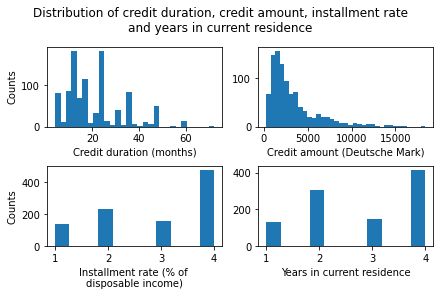

In [4]:
# Distribution of the first four non-categorical features 
fig, ax = plt.subplots(2, 2, constrained_layout=True)

fig.suptitle('Distribution of credit duration, credit amount, installment rate\nand years in current residence')

ax[0, 0].hist(data['duration'], bins='auto')
ax[0, 0].set_xlabel('Credit duration (months)')
ax[0, 0].set_ylabel('Counts')

ax[0, 1].hist(data['credit_amount'], bins='auto')
ax[0, 1].set_xlabel('Credit amount (Deutsche Mark)')

ax[1, 0].hist(data['installment_commitment'], bins='auto')
ax[1, 0].set_xlabel('Installment rate (% of \ndisposable income)')
ax[1, 0].set_ylabel('Counts')

ax[1, 1].hist(data['residence_since'], bins='auto')
ax[1, 1].set_xlabel('Years in current residence')

non_cat_cols = ['duration', 'credit_amount', 'installment_commitment', 'residence_since']

plt.show()

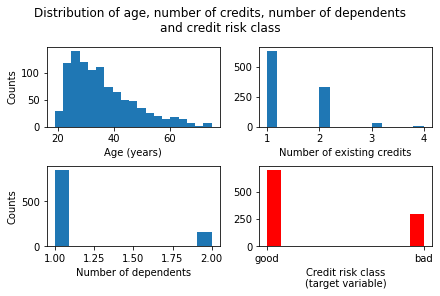

In [5]:
# Distribution of the remaining non-categorical features as well as the target 
fig, ax = plt.subplots(2, 2, constrained_layout=True)

fig.suptitle('Distribution of age, number of credits, number of dependents\nand credit risk class')

ax[0, 0].hist(data['age'], bins='auto')
ax[0, 0].set_xlabel('Age (years)')
ax[0, 0].set_ylabel('Counts')

ax[0, 1].hist(data['existing_credits'], bins='auto')
ax[0, 1].set_xlabel('Number of existing credits')

ax[1, 0].hist(data['num_dependents'], bins='auto')
ax[1, 0].set_xlabel('Number of dependents')
ax[1, 0].set_ylabel('Counts')

ax[1, 1].hist(data['class'], color='r', bins='auto')
ax[1, 1].set_xlabel('Credit risk class\n(target variable)')

non_cat_cols.extend(['age', 'existing_credits', 'num_dependents'])
cat_cols = [col for col in data.columns if col not in non_cat_cols and col != 'class']

plt.show()

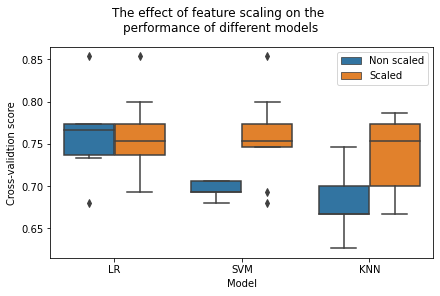

In [6]:
# Train-test-validation split
X = data.loc[:, data.columns != 'class']
y = data['class']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=0)

# Initializing variables for storing the score data
score_data = {'Model': [], 'Preprocessing': [], 'Scores': []}
model_data = [('LR', LogisticRegression()), ('SVM', LinearSVC()), ('KNN', KNeighborsClassifier())]

# Perform only the required preprocessing of categorical features
X_train_val_trans = pd.get_dummies(X_train_val, columns=cat_cols)

for name, model in model_data:
    score_data['Model'].append(name)
    score_data['Preprocessing'].append('Non scaled')
    score_data['Scores'].append(cross_val_score(model, X_train_val_trans, y_train_val, cv=10))

# Creating column transformer and fitting with pipelines
col_trans = ColumnTransformer([
    ('cont', RobustScaler(), ['duration', 'credit_amount', 'age']),
    ('disc', MinMaxScaler(), ['installment_commitment', 'residence_since', 'existing_credits', 'num_dependents']),
    ('cat', OneHotEncoder(), cat_cols)
])

for name, model in model_data:
    score_data['Model'].append(name)
    score_data['Preprocessing'].append('Scaled')
    score_data['Scores'].append(cross_val_score(make_pipeline(col_trans, model), X_train_val, y_train_val, cv=10))

# Box plots of the models' performance 
fig, ax = plt.subplots(constrained_layout=True)

fig.suptitle('The effect of feature scaling on the \nperformance of different models')
ax.set_xlabel('Model')
ax.set_ylabel('Cross-validtion score')

sns.boxplot(x=score_data['Model'], y=score_data['Scores'], hue=score_data['Preprocessing'], ax=ax)

ax.legend()

plt.show()

In [17]:
# Create pipeline and parameter grid (leaving out transformer tunning for simplicity of visualization)
pipe = Pipeline([
    ('trans', col_trans),
    ('clf', LogisticRegression())
])

param_grid = [
    {'clf': [LogisticRegression(penalty='elasticnet', solver='saga')],
     'clf__C': np.logspace(-2, 3, 6),
     'clf__l1_ratio': np.linspace(0, 1, 6)},
    {'clf': [LinearSVC()],
     'clf__C': np.logspace(-2, 3, 6),
     'clf__loss': ['hinge', 'squared_hinge']},
    {'clf': [KNeighborsClassifier()],
     'clf__n_neighbors': np.arange(1, 10),
     'clf__weights': ['uniform', 'distance']}
]

# Perform grid search
grid = GridSearchCV(pipe, param_grid)
grid.fit(X_train_val, y_train_val)

print('Best validation score: ', grid.best_score_,
      '\nBest parameters: ', grid.best_params_,
      '\nTest score of the best parameters: ', grid.score(X_test, y_test))

Best validation score:  0.7653333333333333 
Best parameters:  {'clf': LinearSVC(C=0.1), 'clf__C': 0.1, 'clf__loss': 'squared_hinge'} 
Test score of the best parameters:  0.732


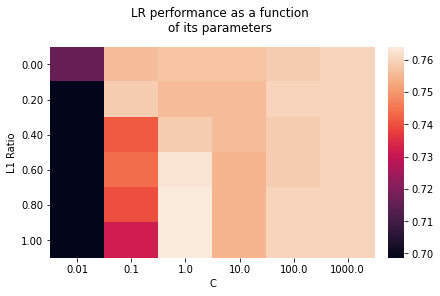

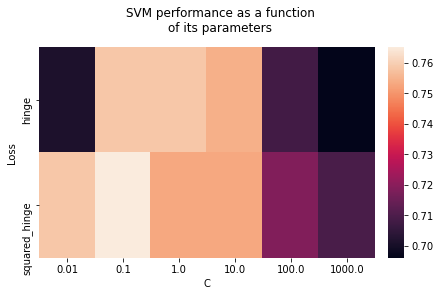

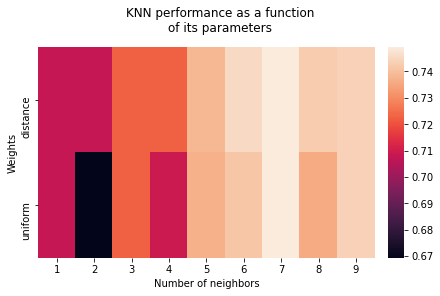

In [8]:
# Transforming the CV results into a Dataframe for a simpler handling
cv_res = pd.DataFrame(grid.cv_results_)

# Visualizing the performance of LR as a function of its parameters
fig1, ax1 = plt.subplots(constrained_layout=True)
fig1.suptitle('LR performance as a function\nof its parameters')

lr_rows = cv_res[cv_res['param_clf'].apply(lambda x: isinstance(x, LogisticRegression))]

sns.heatmap(lr_rows.pivot('param_clf__l1_ratio', 'param_clf__C', 'mean_test_score'), ax=ax1)

ax1.set_xlabel('C')
ax1.set_ylabel('L1 Ratio')
ax1.set_yticklabels(['{:.2f}'.format(float(t.get_text())) for t in ax1.get_yticklabels()]) 

# Visualizing the performance of SVM as a function of its parameters
fig2, ax2 = plt.subplots(1, constrained_layout=True)
fig2.suptitle('SVM performance as a function\nof its parameters')

svm_rows = cv_res[cv_res['param_clf'].apply(lambda x: isinstance(x, LinearSVC))]

sns.heatmap(svm_rows.pivot('param_clf__loss', 'param_clf__C', 'mean_test_score'), ax=ax2)

ax2.set_xlabel('C')
ax2.set_ylabel('Loss')

# Visualizing the performance of KNN as a function of its parameters
fig3, ax3 = plt.subplots(1, constrained_layout=True)
fig3.suptitle('KNN performance as a function\nof its parameters')

knn_rows = cv_res[cv_res['param_clf'].apply(lambda x: isinstance(x, KNeighborsClassifier))]

sns.heatmap(knn_rows.pivot('param_clf__weights', 'param_clf__n_neighbors', 'mean_test_score'), ax=ax3)

ax3.set_xlabel('Number of neighbors')
ax3.set_ylabel('Weights')

plt.show()

In [25]:
# Assessing the effect in the results of using unstratified k-fold and changing the random seeds
params_dict = {'Strategy': ['Stratified K-Fold'], 'Best Parameters': [grid.best_params_], 'Test Score': [grid.score(X_test, y_test)]}

# K-Fold with shuffling (fixed seed)
k_fold_shuffle1_grid = GridSearchCV(pipe, param_grid, cv=KFold(random_state=0, shuffle=True))
k_fold_shuffle1_grid.fit(X_train_val, y_train_val)

params_dict['Strategy'].append('K-Fold with Shuffling (seed = 0)')
params_dict['Best Parameters'].append(k_fold_shuffle1_grid.best_params_)
params_dict['Test Score'].append(k_fold_shuffle1_grid.score(X_test, y_test))

# K-Fold with shuffling (changing seed)
k_fold_shuffle2_grid = GridSearchCV(pipe, param_grid, cv=KFold(random_state=1, shuffle=True))
k_fold_shuffle2_grid.fit(X_train_val, y_train_val)

params_dict['Strategy'].append('K-Fold with Shuffling (seed = 1)')
params_dict['Best Parameters'].append(k_fold_shuffle2_grid.best_params_)
params_dict['Test Score'].append(k_fold_shuffle2_grid.score(X_test, y_test))
    
# Print results
display(pd.DataFrame(params_dict))

,Strategy,Best Parameters,Test Score
0,Stratified K-Fold,"{'clf': LinearSVC(loss='hinge'), 'clf__C': 0.1, 'clf__loss': 'squared_hinge'}",0.732
1,K-Fold with Shuffling (seed = 0),"{'clf': LinearSVC(loss='hinge'), 'clf__C': 1.0, 'clf__loss': 'hinge'}",0.732
2,K-Fold with Shuffling (seed = 1),"{'clf': LogisticRegression(C=0.1, l1_ratio=0.0, penalty='elasticnet', solver='saga'), 'clf__C': 0.1, 'clf__l1_ratio': 0.0}",0.752
